# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter. 

In [ ]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/assignment3"
if not os.path.exists(datadir):
  !ln -s "/content/drive/My Drive/Your/assignment3/path/" $datadir # TODO: Fill your assignment3 path
os.chdir(datadir)
!pwd

# Data Setup

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random


def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img
    elif rot == 1:
        return torchvision.transforms.functional.rotate(img, 90)
    elif rot == 2:
        return torchvision.transforms.functional.rotate(img, 180)
    elif rot == 3:
        return torchvision.transforms.functional.rotate(img, 270)
    # TODO: Implement rotate_img() - return the rotated img
    #
    #
    #
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')


class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:04<00:00, 39.8MB/s] 


Show some example images and rotated images with labels:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


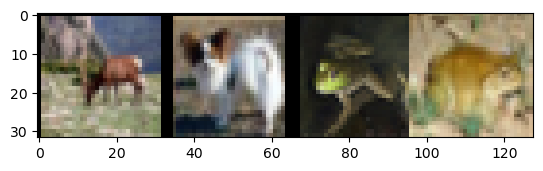

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class labels:  deer  dog   frog  frog 


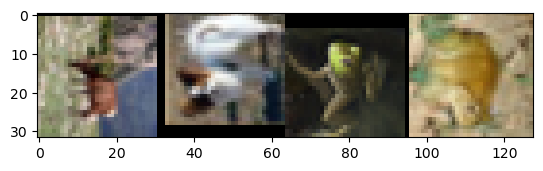

Rotation labels:  270   90    270   270  


In [3]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

# Evaluation code

In [4]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            # TODO: Calculate outputs by running images through the network
            outputs = net(images)
            # The class with the highest energy is what we choose as prediction
            _, p = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (p == labels).sum().item()
            #
            #
            #

            # loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [5]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

## 1. Train a ResNet18 on the rotation task

In this section, we will train a ResNet18 model on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [8]:
import torch.optim as optim

# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [9]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            #
            if task == 'rotation':
              images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
              images, labels = imgs.to(device), cls_label.to(device)
            # TODO: Zero the parameter gradients
            #
            optimizer.zero_grad()
            # TODO: forward + backward + optimize
            #
            #
            #
            #
            #
            outputs = net(images).to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # TODO: Get predicted results
            _, predicted = torch.max(outputs, 1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        #
        #
        net.eval()
        run_test(net, testloader, criterion, task)

    print('Finished Training')

In [10]:
train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation')

# TODO: Save the model
#
torch.save(net.state_dict(), 'my_model')

[1,   100] loss: 1.508 acc: 35.45 time: 3.44
[1,   200] loss: 1.246 acc: 44.66 time: 2.51
[1,   300] loss: 1.209 acc: 46.35 time: 6.00
TESTING:
Accuracy of the network on the 10000 test images: 50.43 %
Average loss on the 10000 test images: 1.122
[2,   100] loss: 1.134 acc: 50.59 time: 2.67
[2,   200] loss: 1.113 acc: 51.28 time: 2.57
[2,   300] loss: 1.089 acc: 53.07 time: 2.69
TESTING:
Accuracy of the network on the 10000 test images: 54.45 %
Average loss on the 10000 test images: 1.083
[3,   100] loss: 1.067 acc: 53.95 time: 2.84
[3,   200] loss: 1.049 acc: 54.89 time: 2.90
[3,   300] loss: 1.031 acc: 55.92 time: 2.87
TESTING:
Accuracy of the network on the 10000 test images: 56.09 %
Average loss on the 10000 test images: 1.009
[4,   100] loss: 1.012 acc: 56.47 time: 6.47
[4,   200] loss: 1.016 acc: 56.10 time: 2.82
[4,   300] loss: 0.991 acc: 58.05 time: 2.79
TESTING:
Accuracy of the network on the 10000 test images: 61.02 %
Average loss on the 10000 test images: 0.934
[5,   100] l

## 2.1 Fine-tuning on the pre-trained model

In this section, we will load the pre-trained ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [11]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
#
#
#
net = resnet18(num_classes=4).to(device)
net.load_state_dict(torch.load('my_model'))
net.fc = nn.Linear(net.fc.in_features, 10).to(device)


In [12]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
#
#
#
#
for name, param in net.named_parameters():
    if not ("layer4" in name or "fc" in name):
        param.requires_grad = False

In [13]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [14]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [15]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

torch.save(net.state_dict(), 'fine_tuned_pre_trained')


[1,   100] loss: 1.732 acc: 36.27 time: 3.00
[1,   200] loss: 1.498 acc: 44.83 time: 3.00
[1,   300] loss: 1.449 acc: 47.29 time: 6.38
TESTING:
Accuracy of the network on the 10000 test images: 49.96 %
Average loss on the 10000 test images: 1.389
[2,   100] loss: 1.391 acc: 49.85 time: 2.99
[2,   200] loss: 1.376 acc: 50.23 time: 2.90
[2,   300] loss: 1.342 acc: 51.48 time: 2.89
TESTING:
Accuracy of the network on the 10000 test images: 53.84 %
Average loss on the 10000 test images: 1.284
[3,   100] loss: 1.320 acc: 52.41 time: 2.96
[3,   200] loss: 1.317 acc: 52.54 time: 2.76
[3,   300] loss: 1.313 acc: 52.45 time: 2.76
TESTING:
Accuracy of the network on the 10000 test images: 53.76 %
Average loss on the 10000 test images: 1.282
[4,   100] loss: 1.293 acc: 53.73 time: 6.46
[4,   200] loss: 1.280 acc: 53.61 time: 2.72
[4,   300] loss: 1.280 acc: 54.04 time: 2.70
TESTING:
Accuracy of the network on the 10000 test images: 55.95 %
Average loss on the 10000 test images: 1.234
[5,   100] l

## 2.2 Fine-tuning on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [16]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
#
#
#
net = resnet18(num_classes=10).to(device)

In [17]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
# To do this, you should set requires_grad=False for the frozen layers.
#
#
#
for name, param in net.named_parameters():
    if not ("layer4" in name or "fc" in name):
        param.requires_grad = False

In [18]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [19]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [20]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

torch.save(net.state_dict(), 'fine_tuned_random')

[1,   100] loss: 2.262 acc: 24.57 time: 2.74
[1,   200] loss: 1.933 acc: 30.59 time: 2.76
[1,   300] loss: 1.849 acc: 33.66 time: 2.80
TESTING:
Accuracy of the network on the 10000 test images: 37.22 %
Average loss on the 10000 test images: 1.720
[2,   100] loss: 1.808 acc: 34.38 time: 2.64
[2,   200] loss: 1.784 acc: 35.59 time: 2.53
[2,   300] loss: 1.751 acc: 36.66 time: 2.56
TESTING:
Accuracy of the network on the 10000 test images: 39.09 %
Average loss on the 10000 test images: 1.689
[3,   100] loss: 1.741 acc: 36.94 time: 2.57
[3,   200] loss: 1.731 acc: 37.88 time: 2.57
[3,   300] loss: 1.732 acc: 37.20 time: 2.51
TESTING:
Accuracy of the network on the 10000 test images: 39.76 %
Average loss on the 10000 test images: 1.664
[4,   100] loss: 1.711 acc: 37.93 time: 2.55
[4,   200] loss: 1.703 acc: 38.15 time: 2.51
[4,   300] loss: 1.713 acc: 38.48 time: 2.50
TESTING:
Accuracy of the network on the 10000 test images: 41.12 %
Average loss on the 10000 test images: 1.619
[5,   100] l

## 3.1 Supervised training on the pre-trained model
In this section, we will load the pre-trained ResNet18 model and re-train the whole model on the classification task.

In [21]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
#
#
#
net = resnet18(num_classes=4).to(device)
net.load_state_dict(torch.load('my_model'))
net.fc = nn.Linear(net.fc.in_features, 10).to(device)

In [22]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [23]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

torch.save(net.state_dict(), 'supervised_pre_trained')

[1,   100] loss: 1.465 acc: 46.36 time: 2.77
[1,   200] loss: 1.146 acc: 59.03 time: 2.68
[1,   300] loss: 1.062 acc: 62.55 time: 2.70
TESTING:
Accuracy of the network on the 10000 test images: 65.58 %
Average loss on the 10000 test images: 1.007
[2,   100] loss: 0.951 acc: 66.44 time: 2.79
[2,   200] loss: 0.929 acc: 67.07 time: 2.67
[2,   300] loss: 0.892 acc: 68.57 time: 2.71
TESTING:
Accuracy of the network on the 10000 test images: 69.69 %
Average loss on the 10000 test images: 0.883
[3,   100] loss: 0.825 acc: 71.20 time: 2.85
[3,   200] loss: 0.833 acc: 70.99 time: 2.88
[3,   300] loss: 0.784 acc: 72.57 time: 3.03
TESTING:
Accuracy of the network on the 10000 test images: 72.43 %
Average loss on the 10000 test images: 0.796
[4,   100] loss: 0.753 acc: 73.96 time: 3.30
[4,   200] loss: 0.745 acc: 73.77 time: 6.83
[4,   300] loss: 0.738 acc: 74.27 time: 3.03
TESTING:
Accuracy of the network on the 10000 test images: 74.55 %
Average loss on the 10000 test images: 0.742
[5,   100] l

## 3.2 Supervised training on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [24]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
#
#
#
net = resnet18(num_classes=10).to(device)

In [25]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [26]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

torch.save(net.state_dict(), 'supervised_random')

[1,   100] loss: 2.324 acc: 20.55 time: 3.04
[1,   200] loss: 1.893 acc: 30.59 time: 6.51
[1,   300] loss: 1.756 acc: 36.26 time: 3.02
TESTING:
Accuracy of the network on the 10000 test images: 41.11 %
Average loss on the 10000 test images: 1.630
[2,   100] loss: 1.542 acc: 43.65 time: 3.37
[2,   200] loss: 1.483 acc: 45.38 time: 2.81
[2,   300] loss: 1.417 acc: 48.93 time: 3.08
TESTING:
Accuracy of the network on the 10000 test images: 54.43 %
Average loss on the 10000 test images: 1.293
[3,   100] loss: 1.279 acc: 53.65 time: 3.54
[3,   200] loss: 1.247 acc: 55.30 time: 3.51
[3,   300] loss: 1.203 acc: 56.71 time: 7.19
TESTING:
Accuracy of the network on the 10000 test images: 60.67 %
Average loss on the 10000 test images: 1.138
[4,   100] loss: 1.108 acc: 60.20 time: 3.57
[4,   200] loss: 1.073 acc: 61.95 time: 3.36
[4,   300] loss: 1.046 acc: 62.52 time: 2.96
TESTING:
Accuracy of the network on the 10000 test images: 63.87 %
Average loss on the 10000 test images: 1.051
[5,   100] l

## 4.1 Improved Model for Rotation Task
In this section, we will use DenseNet to try to improve part 1 by 3% accuracy. We are aiming for 78.77% + 3% = 81.77% accuracy.

In [36]:
import torchvision.models as models

net = models.densenet121(pretrained=True)
net.classifier = nn.Linear(net.classifier.in_features, 4)
net = net.to(device)

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4)

In [38]:
train(net, criterion, optimizer, num_epochs=100, decay_epochs=25, init_lr=0.01, task='rotation')

torch.save(net.state_dict(), 'DenseNet_rotation')

[1,   100] loss: 1.721 acc: 25.53 time: 7.59
[1,   200] loss: 1.586 acc: 25.23 time: 9.10
[1,   300] loss: 1.504 acc: 25.73 time: 7.28
TESTING:
Accuracy of the network on the 10000 test images: 37.95 %
Average loss on the 10000 test images: 2.494
[2,   100] loss: 1.382 acc: 38.14 time: 7.18
[2,   200] loss: 1.399 acc: 37.27 time: 7.11
[2,   300] loss: 1.337 acc: 39.22 time: 7.29
TESTING:
Accuracy of the network on the 10000 test images: 43.27 %
Average loss on the 10000 test images: 1.317
[3,   100] loss: 1.232 acc: 42.91 time: 8.05
[3,   200] loss: 1.187 acc: 45.97 time: 10.13
[3,   300] loss: 1.168 acc: 47.30 time: 10.12
TESTING:
Accuracy of the network on the 10000 test images: 50.63 %
Average loss on the 10000 test images: 1.117
[4,   100] loss: 1.130 acc: 50.11 time: 9.07
[4,   200] loss: 1.120 acc: 50.75 time: 17.64
[4,   300] loss: 1.100 acc: 51.67 time: 9.63
TESTING:
Accuracy of the network on the 10000 test images: 54.66 %
Average loss on the 10000 test images: 1.094
[5,   100

## 4.2 Improved Model for Classification Task
In this section, we will use DenseNet to try to improve part 3.1 by 3% accuracy. We are aiming for 84.22% + 3% = 87.22% accuracy.

In [39]:
net = models.densenet121(num_classes=4).to(device)
net.load_state_dict(torch.load('DenseNet_rotation'))
net.classifier = nn.Linear(net.classifier.in_features, 10).to(device)

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08)

In [41]:
train(net, criterion, optimizer, num_epochs=100, decay_epochs=25, init_lr=0.01, task='classification')

torch.save(net.state_dict(), 'DenseNet_classification')

[1,   100] loss: 1.441 acc: 46.16 time: 4.98
[1,   200] loss: 1.149 acc: 58.50 time: 5.08
[1,   300] loss: 1.052 acc: 62.62 time: 5.77
TESTING:
Accuracy of the network on the 10000 test images: 58.20 %
Average loss on the 10000 test images: 1.212
[2,   100] loss: 0.940 acc: 66.48 time: 5.59
[2,   200] loss: 0.926 acc: 67.22 time: 5.66
[2,   300] loss: 0.869 acc: 69.30 time: 5.62
TESTING:
Accuracy of the network on the 10000 test images: 69.88 %
Average loss on the 10000 test images: 0.872
[3,   100] loss: 0.831 acc: 70.53 time: 9.84
[3,   200] loss: 0.834 acc: 70.72 time: 7.03
[3,   300] loss: 0.815 acc: 71.18 time: 5.43
TESTING:
Accuracy of the network on the 10000 test images: 70.81 %
Average loss on the 10000 test images: 0.829
[4,   100] loss: 0.770 acc: 72.84 time: 6.00
[4,   200] loss: 0.766 acc: 73.31 time: 10.13
[4,   300] loss: 0.764 acc: 73.35 time: 6.39
TESTING:
Accuracy of the network on the 10000 test images: 74.38 %
Average loss on the 10000 test images: 0.735
[5,   100] 